In [1]:
#TODO visualize the train valid test split in adjacency matrix 

import os
import sys
sys.path.insert(0, '/hkfs/work/workspace/scratch/cc7738-benchmark_tag/TAPE_chen/core')

from data_utils.load_data_nc import load_graph_cora, load_graph_pubmed, load_tag_arxiv23, load_graph_ogbn_arxiv
from torch_geometric import seed_everything
from graphgps.encoder.seal import get_pos_neg_edges, extract_enclosing_subgraphs, k_hop_subgraph, construct_pyg_graph, do_edge_split
import copy
import os
import sys
# Add the project's root directory to the system path


import copy
import time
import argparse

import torch
import scipy.sparse as ssp
from torch_geometric import seed_everything
from torch_geometric.graphgym.utils.device import auto_select_device
from torch_geometric.data import InMemoryDataset, Dataset

from graphgps.train.seal_train import Trainer_SEAL
from graphgps.network.heart_gnn import DGCNN
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

/home/hk-project-test-p0021478/cc7738/anaconda3/envs/EAsF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
name = 'cora'
val_pct = 0.15
test_pct = 0.05

In [3]:
seed_everything(0)
if name == 'pubmed':
    data = load_graph_pubmed(False)
elif name == 'cora':
    data, _ = load_graph_cora(False)
elif name == 'arxiv_2023':
    data, _ = load_tag_arxiv23()
elif name == 'ogbn-arxiv':
    data = load_graph_ogbn_arxiv(False)
splits = do_edge_split(copy.deepcopy(data), val_pct,  test_pct)

/home/hk-project-test-p0021478/cc7738/anaconda3/envs/EAsF/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [20]:
class SEALDataset(InMemoryDataset):
    def __init__(self, root, data, splits, num_hops, percent=100, split='train',node_label='drnl', ratio_per_hop=1.0,
                 max_nodes_per_hop=None, directed=False):
        self.data = data
        self.split_edge = splits
        self.num_hops = num_hops
        self.percent = int(percent) if percent >= 1.0 else percent
        self.split = split
        self.node_label = node_label
        self.ratio_per_hop = ratio_per_hop
        self.max_nodes_per_hop = max_nodes_per_hop
        self.directed = directed
        super(SEALDataset, self).__init__(root)
        self.data, self.slices = torch.load(self.processed_paths[0])


    @property
    def processed_file_names(self):
        if self.percent == 100:
            name = 'SEAL_{}_data'.format(self.split)
        else:
            name = 'SEAL_{}_data_{}'.format(self.split, self.percent)
        name += '.pt'
        return [name]

    def process(self):
        pos_edge, neg_edge = get_pos_neg_edges(self.split, self.split_edge,
                                               self.data.edge_index,
                                               self.data.num_nodes,
                                               self.percent)
        if 'edge_weight' in self.data:
            edge_weight = self.data.edge_weight.view(-1)
        else:
            edge_weight = torch.ones(self.data.edge_index.size(1), dtype=int)

        edge_weight_cpu = edge_weight.cpu()
        edge_index_cpu = self.data.edge_index.cpu()

        A = ssp.csr_matrix(
            (edge_weight_cpu, (edge_index_cpu[0], edge_index_cpu[1])),
            shape=(self.data.num_nodes, self.data.num_nodes)
        )

        A_csc = A.tocsc() if self.directed else None
        
        # Extract enclosing subgraphs for pos and neg edges
        pos_list = extract_enclosing_subgraphs(
            pos_edge, A, self.data.x, 1, self.num_hops, self.node_label,
            self.ratio_per_hop, self.max_nodes_per_hop, self.directed, A_csc)
        neg_list = extract_enclosing_subgraphs(
            neg_edge, A, self.data.x, 0, self.num_hops, self.node_label,
            self.ratio_per_hop, self.max_nodes_per_hop, self.directed, A_csc)

        torch.save(self.collate(pos_list + neg_list), self.processed_paths[0])
        del pos_list, neg_list

In [21]:
# visualize it using adajcency plot visualization/..adj
dataset = {}

dataset['train'] = SEALDataset(
    './generated_data',
    data,
    splits,
    num_hops=2,
    split='train',
    node_label= 1,
    directed=not True,
)

dataset['valid'] = SEALDataset(
    './generated_data',
    data,
    splits,
    num_hops=2,
    split='valid',
    node_label= 'drnl',
    directed=not True,
)

dataset['test'] = SEALDataset(
    './generated_data',
    data,
    splits,
    num_hops=2,
    split='test',
    node_label= 'drnl',
    directed=not True,
)

In [22]:
#  these funcs are not from pytorch.geometric, visualize and calculate some graph statistic such as degree distribution
# avg, avg^2
extract_enclosing_subgraphs
k_hop_subgraph

<function graphgps.encoder.seal.k_hop_subgraph(src, dst, num_hops, A, sample_ratio=1.0, max_nodes_per_hop=None, node_features=None, y=1, directed=False, A_csc=None)>

In [23]:
train_loader = DataLoader(dataset['train'], batch_size=2, shuffle=True)
for subgraph in train_loader:
    data = subgraph.to('cpu')
    print(data)

DataBatch(x=[474, 1433], edge_index=[2, 1728], y=[2], edge_weight=[1728], z=[474], node_id=[474], num_nodes=474, batch=[474], ptr=[3])
DataBatch(x=[226, 1433], edge_index=[2, 862], y=[2], edge_weight=[862], z=[226], node_id=[226], num_nodes=226, batch=[226], ptr=[3])
DataBatch(x=[130, 1433], edge_index=[2, 562], y=[2], edge_weight=[562], z=[130], node_id=[130], num_nodes=130, batch=[130], ptr=[3])
DataBatch(x=[197, 1433], edge_index=[2, 844], y=[2], edge_weight=[844], z=[197], node_id=[197], num_nodes=197, batch=[197], ptr=[3])
DataBatch(x=[115, 1433], edge_index=[2, 330], y=[2], edge_weight=[330], z=[115], node_id=[115], num_nodes=115, batch=[115], ptr=[3])
DataBatch(x=[85, 1433], edge_index=[2, 256], y=[2], edge_weight=[256], z=[85], node_id=[85], num_nodes=85, batch=[85], ptr=[3])
DataBatch(x=[67, 1433], edge_index=[2, 224], y=[2], edge_weight=[224], z=[67], node_id=[67], num_nodes=67, batch=[67], ptr=[3])
DataBatch(x=[88, 1433], edge_index=[2, 258], y=[2], edge_weight=[258], z=[88]

KeyboardInterrupt: 

In [24]:
splits

{'train': {'edge': tensor([[   0,  258],
          [   0,  435],
          [   1,  344],
          ...,
          [2707,  774],
          [2707, 1389],
          [2707, 2344]]),
  'edge_neg': tensor([[2616, 2011],
          [1193, 2221],
          [2348, 2146],
          ...,
          [1236, 2224],
          [1102,  700],
          [2534, 1674]])},
 'valid': {'edge': tensor([[ 603, 1047],
          [ 876, 1006],
          [  45,  220],
          ...,
          [1224, 2673],
          [ 179,  331],
          [2059, 2651]]),
  'edge_neg': tensor([[1925, 2276],
          [ 491, 2333],
          [ 425, 1802],
          ...,
          [ 866, 1776],
          [ 910, 1366],
          [ 472, 1538]])},
 'test': {'edge': tensor([[ 882, 1316],
          [1346, 1451],
          [ 837, 1489],
          [1846, 1927],
          [2614, 2616],
          [ 294,  502],
          [ 719, 1666],
          [ 321,  566],
          [1170, 1198],
          [2480, 2485],
          [2278, 2284],
          [1681,

In [25]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

def get_hist(A, use_heuristic, data, num_nodes):

    # Assuming you have a tensor with node indices
    nodes = torch.arange(num_nodes)
    # Generate pairwise combinations of indices
    pairs = torch.combinations(nodes, r=2).T

    pos_test_pred, _ = eval(use_heuristic)(A, pairs)
    
    data_df = pd.DataFrame({'size': pos_test_pred.numpy()})

    data_df_filtered = data_df[data_df['size'] != 0.0]
    
    plt.figure()
    bin_edges = [0, 1, 3, 10, 25, float('inf')]
    ax = sns.histplot(data=data_df_filtered, kde=False, stat='percent', discrete=True, 
                      color='blue')
    
    # Access the bin edges and heights
    # bin_edges = ax.patches[0].get_x()*ax.patches[-1].get_x() + ax.patches[-1].get_width()
    heights = [patch.get_height() for patch in ax.patches]

    # Print bin edges and heights
    print("Bin Edges:", bin_edges)
    print("Heights:", heights)

    plt.title(f'_{use_heuristic}_filtered')
    plt.xlim(1, 40) 
    plt.xlabel('Num of CN')  # Specify x-axis label
    plt.ylabel('Propotion')   # Specify y-axis label
    plt.show()

In [26]:
data, _ = load_graph_cora(False)

if 'edge_weight' in data:
    edge_weight = data.edge_weight.view(-1)
else:
    edge_weight = torch.ones(data.edge_index.size(1), dtype=int)

edge_weight_cpu = edge_weight.cpu()
edge_index_cpu = data.edge_index.cpu()

A = ssp.csr_matrix(
    (edge_weight_cpu, (edge_index_cpu[0], edge_index_cpu[1])),
    shape=(data.num_nodes, data.num_nodes)
)
data.num_nodes

2708

In [27]:
pos_edge, neg_edge = get_pos_neg_edges('train', splits,
                                        data.edge_index,
                                        data.num_nodes,
                                        1.0)

In [28]:
from tqdm import tqdm
import numpy as np

def CN(A, edge_index, batch_size=100000):
    """
    Common neighbours
    :param A: scipy sparse adjacency matrix
    :param edge_index: pyg edge_index
    :param batch_size: int
    :return: FloatTensor [edges] of scores, pyg edge_index
    """
    edge_index = edge_index.t()
    link_loader = DataLoader(range(edge_index.size(0)), batch_size)
    scores = []
    for ind in tqdm(link_loader):
        src, dst = edge_index[ind, 0], edge_index[ind, 1]
        cur_scores = np.array(np.sum(A[src].multiply(A[dst]), 1)).flatten()
        scores.append(cur_scores)
    scores = np.concatenate(scores, 0)
    print(f'evaluated Common Neighbours for {len(scores)} edges')
    return torch.FloatTensor(scores), edge_index


100%|██████████| 37/37 [00:01<00:00, 20.98it/s]


evaluated Common Neighbours for 3665278 edges
Bin Edges: [0, 1, 3, 10, 25, inf]
Heights: [87.35274940230384, 9.537057161486635, 2.075635731362747, 0.619430558574223, 0.23690502064768526, 0.06737665724842426, 0.04998913279721799, 0.013040643338404694, 0.00869376222560313, 0.013040643338404694, 0.006520321669202347, 0.00869376222560313, 0.004346881112801565, 0.0021734405564007827, 0.0021734405564007827, 0.0, 0.0, 0.0, 0.0, 0.0021734405564007827]


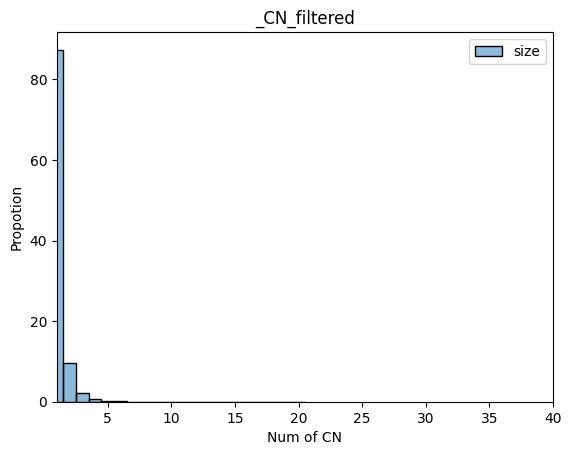

In [29]:
get_hist(A, 'CN', data, data.num_nodes)

In [40]:
def get_test_hist(data_name, pos_test_pred, neg_test_pred, use_heuristic):
   
    bin_edges = [0, 1, 3, 10, 25, float('inf')]
    
    pred = torch.cat([pos_test_pred, neg_test_pred], dim=0)
    hist, bin_edges = np.histogram(pred, bins=bin_edges)
    print(hist)
    hist = hist / hist.sum()
    plt.figure(figsize=(10, 8))
    plt.bar([1, 2, 3, 4, 5], hist)
    
    custom_ticks = [1, 2, 3, 4, 5]
    custom_labels = ['[0-1]', '[1-3]', '[3-10]', '[10-25]', '25-inf']

    
    plt.xticks(custom_ticks, custom_labels)
    plt.title(f'{data_name}_{use_heuristic}_filtered')
    plt.xlabel('Num of CN')  
    plt.ylabel('Propotion')  
    plt.title(f'CN distribution of {data_name}')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=[1, 2, 3, 4, 5], y=hist, color='skyblue')
    plt.xticks([0, 1, 2, 3, 4], ['[0-1]', '[1-3]', '[3-10]', '[10-25]', '25-inf'], fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('CN distribution', fontsize=24)
    plt.xlabel('Num of CN', fontsize=20)
    plt.ylabel('Proportion', fontsize=20)
    plt.show()
        

100%|██████████| 1/1 [00:00<00:00, 221.89it/s]


evaluated Common Neighbours for 85 edges


100%|██████████| 1/1 [00:00<00:00, 248.14it/s]

evaluated Common Neighbours for 85 edges
[124  38   8   0   0]


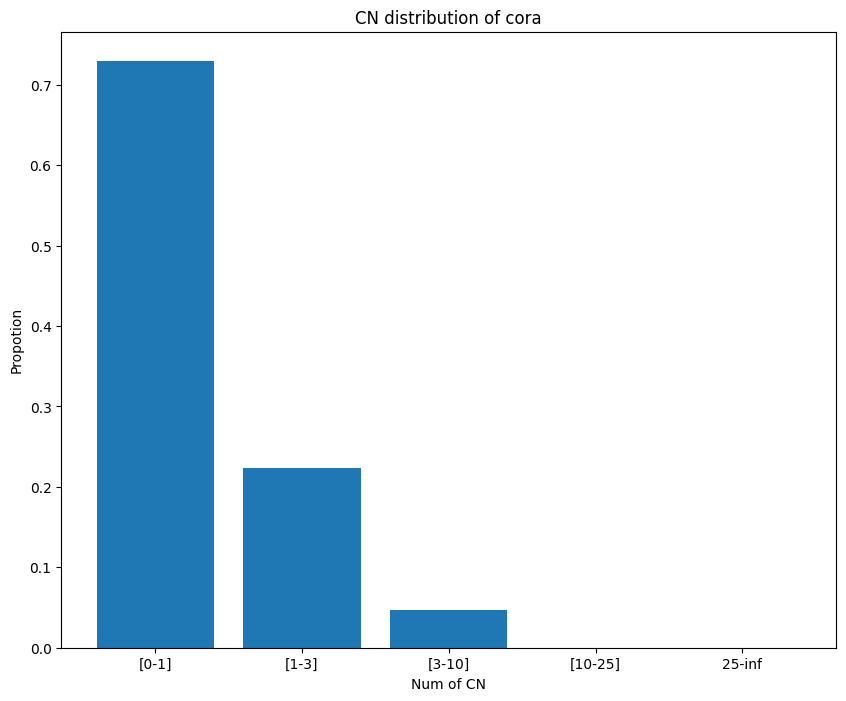

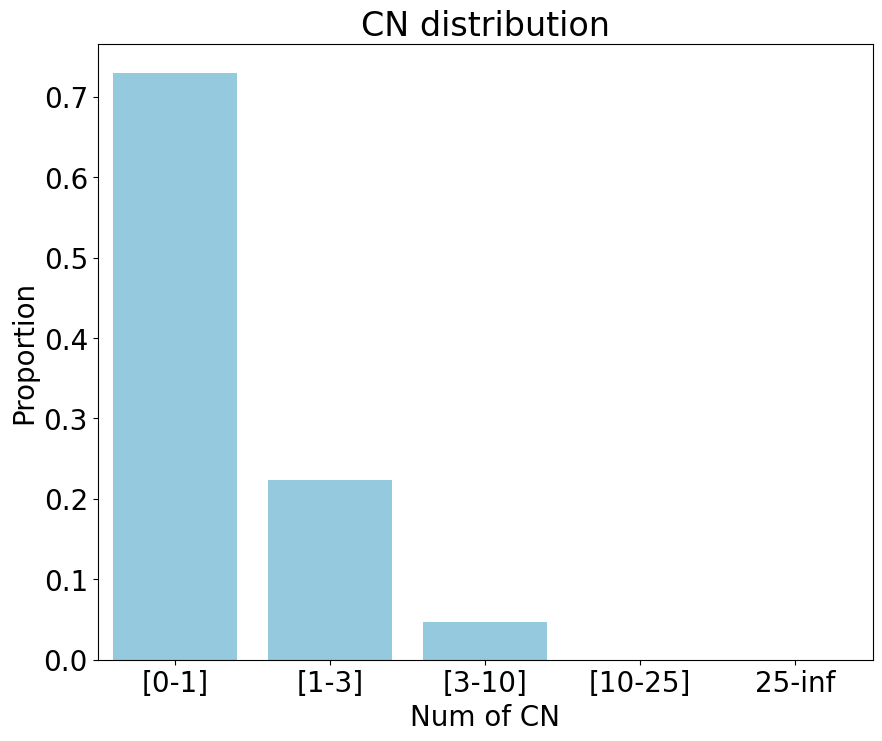

In [41]:
pos_test_pred, _ = CN(A, pos_edge)
neg_test_pred, _ = CN(A, neg_edge)

get_test_hist('cora', pos_test_pred, neg_test_pred,  'CN')

[  0 118  44   8   0   0]


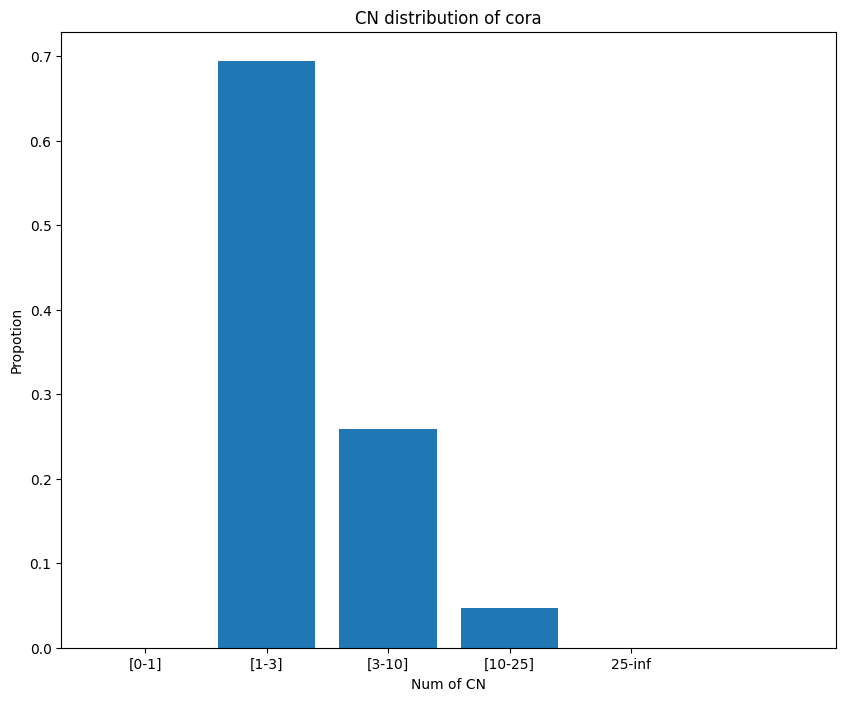

In [16]:
get_test_hist('cora', pos_test_pred, neg_test_pred,  'CN')

100%|██████████| 1/1 [00:00<00:00, 215.16it/s]


evaluated Common Neighbours for 2 edges


100%|██████████| 1/1 [00:00<00:00, 262.72it/s]

evaluated Common Neighbours for 2 edges
[2 0 2 0 0]


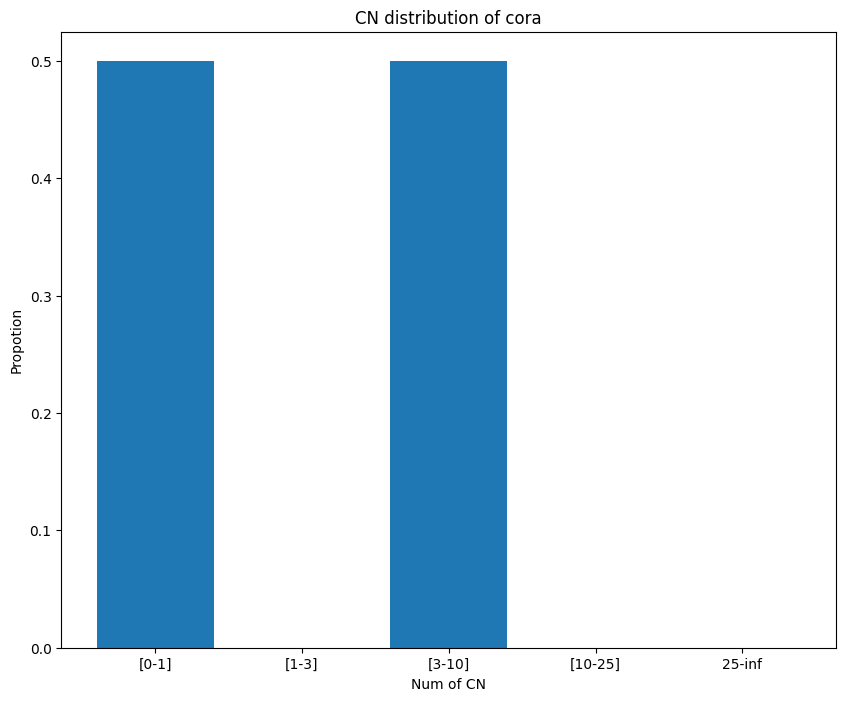

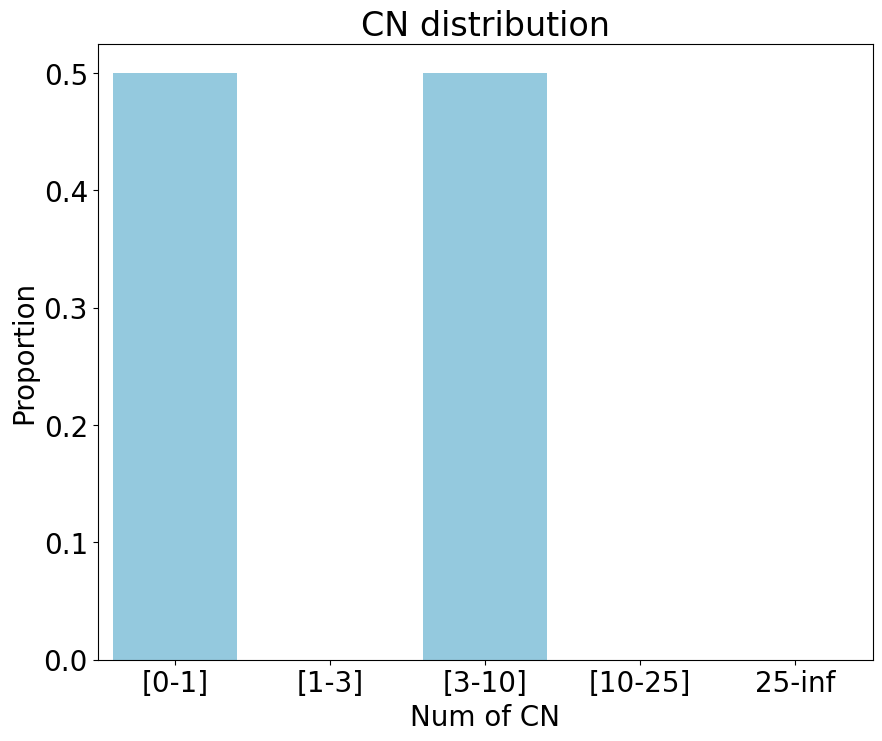

In [42]:
pos_edge = splits['train']['edge']
neg_edge = splits['train']['edge_neg']
pos_test_pred, _ = CN(A, pos_edge)
neg_test_pred, _ = CN(A, neg_edge)

get_test_hist('cora', pos_test_pred, neg_test_pred,  'CN')

100%|██████████| 1/1 [00:00<00:00, 228.25it/s]


evaluated Common Neighbours for 2 edges


100%|██████████| 1/1 [00:00<00:00, 224.86it/s]

evaluated Common Neighbours for 2 edges
[4 0 0 0 0]


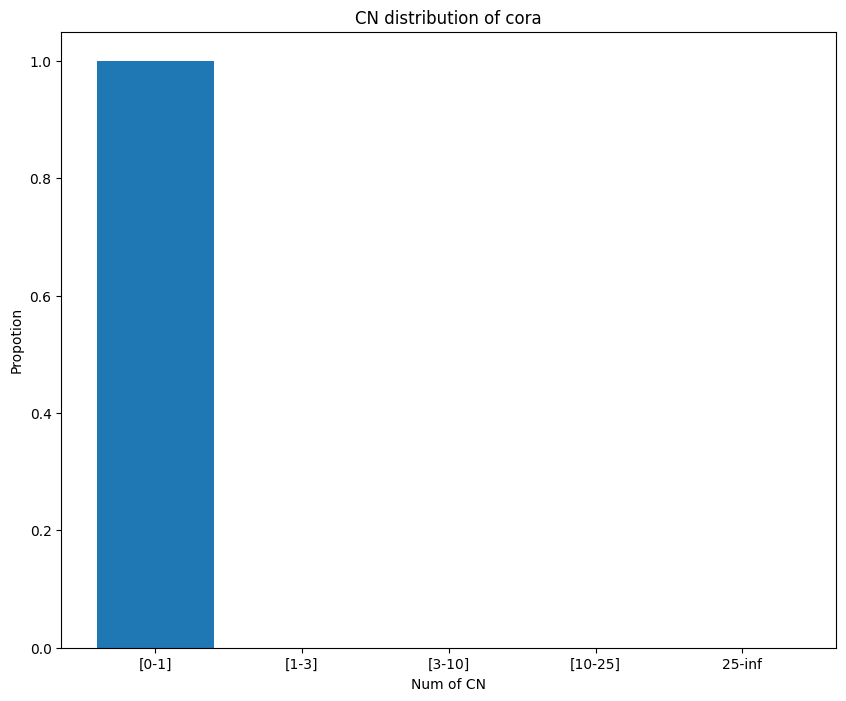

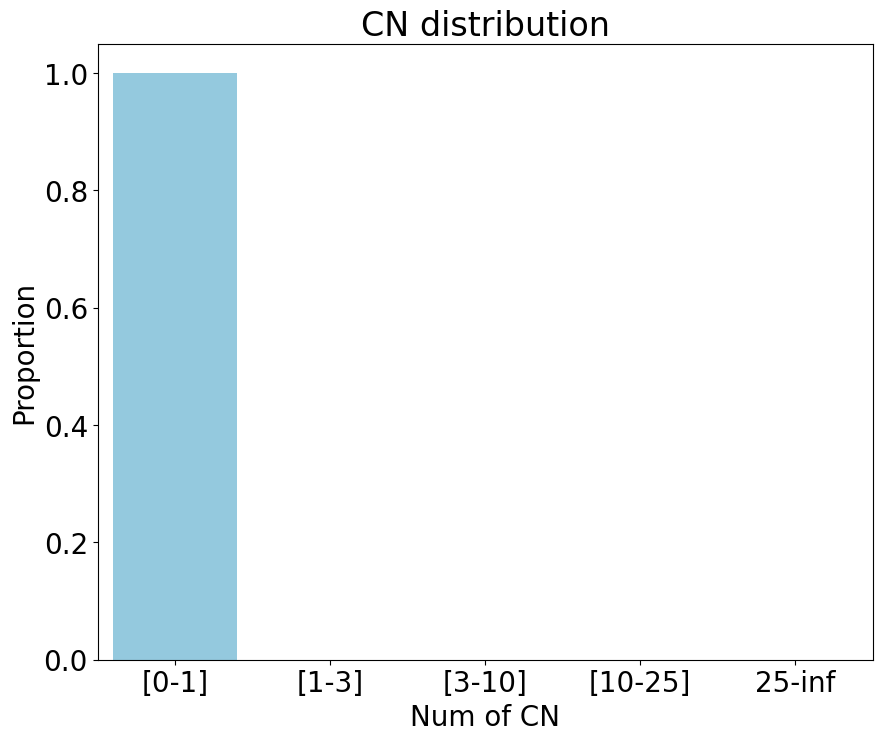

In [43]:
pos_edge = splits['valid']['edge']
neg_edge = splits['valid']['edge_neg']
pos_test_pred, _ = CN(A, pos_edge)
neg_test_pred, _ = CN(A, neg_edge)

get_test_hist('cora', pos_test_pred, neg_test_pred,  'CN')

100%|██████████| 1/1 [00:00<00:00, 204.60it/s]


evaluated Common Neighbours for 2 edges


100%|██████████| 1/1 [00:00<00:00, 259.39it/s]

evaluated Common Neighbours for 2 edges
[4 0 0 0 0]


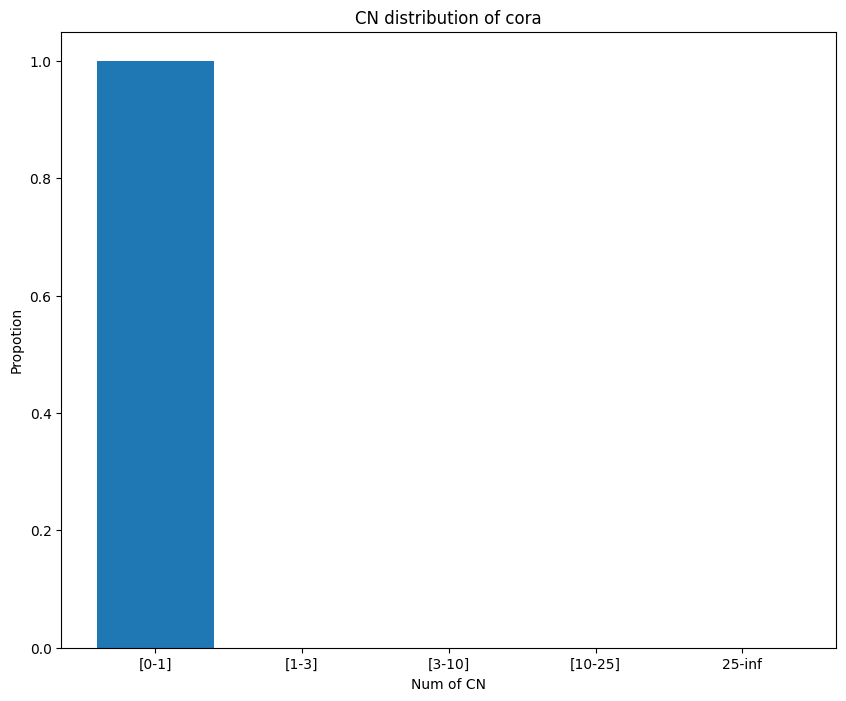

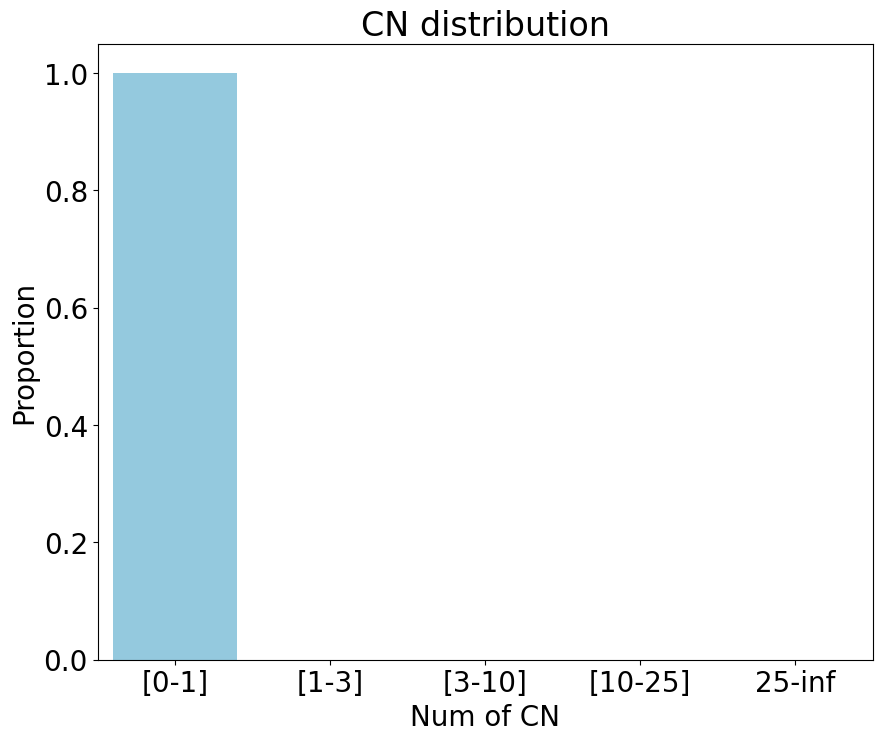

In [44]:
pos_edge = splits['test']['edge']
neg_edge = splits['test']['edge_neg']
pos_test_pred, _ = CN(A, pos_edge)
neg_test_pred, _ = CN(A, neg_edge)

get_test_hist('cora', pos_test_pred, neg_test_pred,  'CN')